<a href="https://colab.research.google.com/github/LeviJunior21/AtividadesPLP/blob/master/Dijkstra_VS_A_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparando o Algoritmo A* vs Dijkstra em Campina Grande.


In [1]:
!pip install osmnx
!pip install moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 2.2 MB/s eta 0:00:00


In [2]:
import osmnx as ox
import random
import heapq
from moviepy.editor import ImageSequenceClip
import matplotlib.pyplot as plt
import os
import shutil

### Importando e limpando o Mapa para restringir a área.

In [3]:
place_name = "Campina Grande, PB, Brazil"

# Especificando o local para observar e como gostariamos de nos deslocar.
G = ox.graph_from_place(place_name, network_type="drive")

In [4]:
# Atribuindo vélocidade máxima permitida e tempo estimado para percorrer a rua.
for edge in G.edges:
    # Velocidade máxima permitida para uma rua qualquer.
    maxspeed = 40

    # Verifica se a velocidade máxima da rua está presente na aresta.
    if "maxspeed" in G.edges[edge]:
        # Velocidade máxima da aresta:
        maxspeed = G.edges[edge]["maxspeed"]

        # Verifica se a velocidade máxima da rua é uma lista.
        # Se for, então existem variações de velocidades permitidas
        # para diferentes horários do dia.
        if isinstance(maxspeed, list):
            speeds = [int(speed) for speed in maxspeed if speed.isdigit()]

            # Vamos dizer que a velócidade máxima permitida é a mínima para
            # aquela rua, para não criar expectativa no motorista de que será
            # rápido de chegar até o fim da aresta.
            maxspeed = min(speeds)
            if speeds:
                maxspeed = min(speeds)
            else:
                maxspeed = 40

        # Ele pode está especificado como string em vez de lista.
        # Iremos tratar isso com split.
        elif isinstance(maxspeed, str):
            if ',' in maxspeed:
                speeds = [int(speed) for speed in maxspeed.split(',') if speed.strip().isdigit()]
                if speeds:
                    maxspeed = min(speeds)
                else:
                    maxspeed = 40
            else:
                maxspeed = int(maxspeed.strip())

    # Velocidade máxima permitida para aquela rua e seu respectivo peso.
    G.edges[edge]["maxspeed"] = maxspeed
    # Atribuindo um tempo médio para sair do início ao fim da aresta.
    G.edges[edge]["weight"] = G.edges[edge]["length"] / maxspeed

### Utilidades visuais

In [5]:
def create_dir(path):
  os.makedirs(path, exist_ok=True)

In [6]:
def style_unvisited_edge(edge):
    G.edges[edge]["color"] = "#d36206"
    G.edges[edge]["alpha"] = 0.2
    G.edges[edge]["linewidth"] = 0.5

def style_visited_edge(edge):
    G.edges[edge]["color"] = "#d36206"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_active_edge(edge):
    G.edges[edge]["color"] = '#e8a900'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_path_edge(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

In [7]:
# Salvando a imagem criada em um diretório caso seja interessante.
def save_image(plt, path, step):
  local_path = f"{path}/frame_{step}.png"
  try:
    plt.savefig(local_path, bbox_inches='tight', pad_inches=0)
  except:
    create_dir(path)
    plt.savefig(local_path, bbox_inches='tight', pad_inches=0)

In [8]:
# Plotar gráfico para os nós já percorridos pelo algortimo.
def plot_graph(path, step, save=False):
    ox.plot_graph(
        G,
        node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
        edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
        edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
        edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
        node_color = "white",
        bgcolor = "#18080e",
        show = False,
        close = False,
        figsize=(22,15)
    )

    if save:
      save_image(plt, path, step)

In [9]:
# Gerando um mapa de calor para identificar ruas que tem maiores e menores
# tráfegos da cidade.
def plot_heatmap(algorithm):
    edge_colors = ox.plot.get_edge_colors_by_attr(G, f"{algorithm}_uses", cmap="hot")
    fig, _ = ox.plot_graph(
        G,
        node_size = 0,
        edge_color = edge_colors,
        bgcolor = "#18080e",
        node_color = "white",
        show = False,
        close = False,
        figsize=(22,15)
    )

## Implementação do Algoritmo

In [10]:
def dijkstra(orig, dest, plot=False, save = False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    pq = [(0, orig)]
    step = 0
    while pq:
        # Plotando o grafo para observarmos o resultado.
        # Observação: Podemos salvar a iteração caso passemos save como True.
        if plot:
          plot_graph("./images/dijkstra", step, save)

        _, node = heapq.heappop(pq)
        if node == dest:
            print("Iterations:", step)
            plot_graph("./images/dijkstra", step, save)
            return
        if G.nodes[node]["visited"]: continue
        G.nodes[node]["visited"] = True
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            weight = G.edges[(edge[0], edge[1], 0)]["weight"]
            if G.nodes[neighbor]["distance"] > G.nodes[node]["distance"] + weight:
                G.nodes[neighbor]["distance"] = G.nodes[node]["distance"] + weight
                G.nodes[neighbor]["previous"] = node
                heapq.heappush(pq, (G.nodes[neighbor]["distance"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

In [11]:
# Heuristica do A* baseado em distância entre dois pontos:
def distance(node1, node2):
    x1, y1 = G.nodes[node1]["x"], G.nodes[node1]["y"]
    x2, y2 = G.nodes[node2]["x"], G.nodes[node2]["y"]
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

def a_star(orig, dest, plot=False, save = False):
    for node in G.nodes:
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
        G.nodes[node]["g_score"] = float("inf")
        G.nodes[node]["f_score"] = float("inf")
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    G.nodes[orig]["g_score"] = 0
    G.nodes[orig]["f_score"] = distance(orig, dest)
    pq = [(G.nodes[orig]["f_score"], orig)]
    step = 0
    while pq:
        # Plotando o grafo para observarmos o resultado.
        # Observação: Podemos salvar a iteração caso passemos save como True.
        if (plot):
            plot_graph("./images/astar", step, save)
        _, node = heapq.heappop(pq)
        if node == dest:
            print("Iterations:", step)
            plot_graph("./images/astar", step, save)
            return
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            tentative_g_score = G.nodes[node]["g_score"] + distance(node, neighbor)
            if tentative_g_score < G.nodes[neighbor]["g_score"]:
                G.nodes[neighbor]["previous"] = node
                G.nodes[neighbor]["g_score"] = tentative_g_score
                G.nodes[neighbor]["f_score"] = tentative_g_score + distance(neighbor, dest)
                heapq.heappush(pq, (G.nodes[neighbor]["f_score"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

In [12]:
# Função que calcula a quantidade existentes de arquivos em um diretório.
def count_archives(path):
  content = os.listdir(path)
  number_of_archives = sum(os.path.isfile(os.path.join(path, item)) for item in content)
  return number_of_archives

In [13]:
# Função que mostra o caminho traçado da origem ao destino e as estatísticas
# sobre o percurso da origem ao destino.
# Temos a opção de salvar a imagem mostrando explicitamente a rota mais rápida.
def reconstruct_path(orig, dest, plot=False, algorithm=None, algorithm_name=""):
    for edge in G.edges:
        style_unvisited_edge(edge)
    dist = 0
    speeds = []
    curr = dest

    while curr != orig:
        prev = G.nodes[curr]["previous"]
        dist += G.edges[(prev, curr, 0)]["length"]
        speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
        style_path_edge((prev, curr, 0))
        if algorithm:
            G.edges[(prev, curr, 0)][f"{algorithm}_uses"] = G.edges[(prev, curr, 0)].get(f"{algorithm}_uses", 0) + 1
        curr = prev
    dist /= 1000

    if plot:
        print(f"Distance: {dist}")
        print(f"Avg. speed: {sum(speeds)/len(speeds)}")
        print(f"Total time: {dist/(sum(speeds)/len(speeds)) * 60}")
        path = f"./images/{algorithm_name}"
        plot_graph(path, count_archives(path), True)

## Comparando os algortimos na visualização do Mapa

In [52]:
# Escolhendo aleatóriamente uma aresta origem e de destino para o mapa.
start = random.choice(list(G.nodes))
end = random.choice(list(G.nodes))

Iterations: 11209


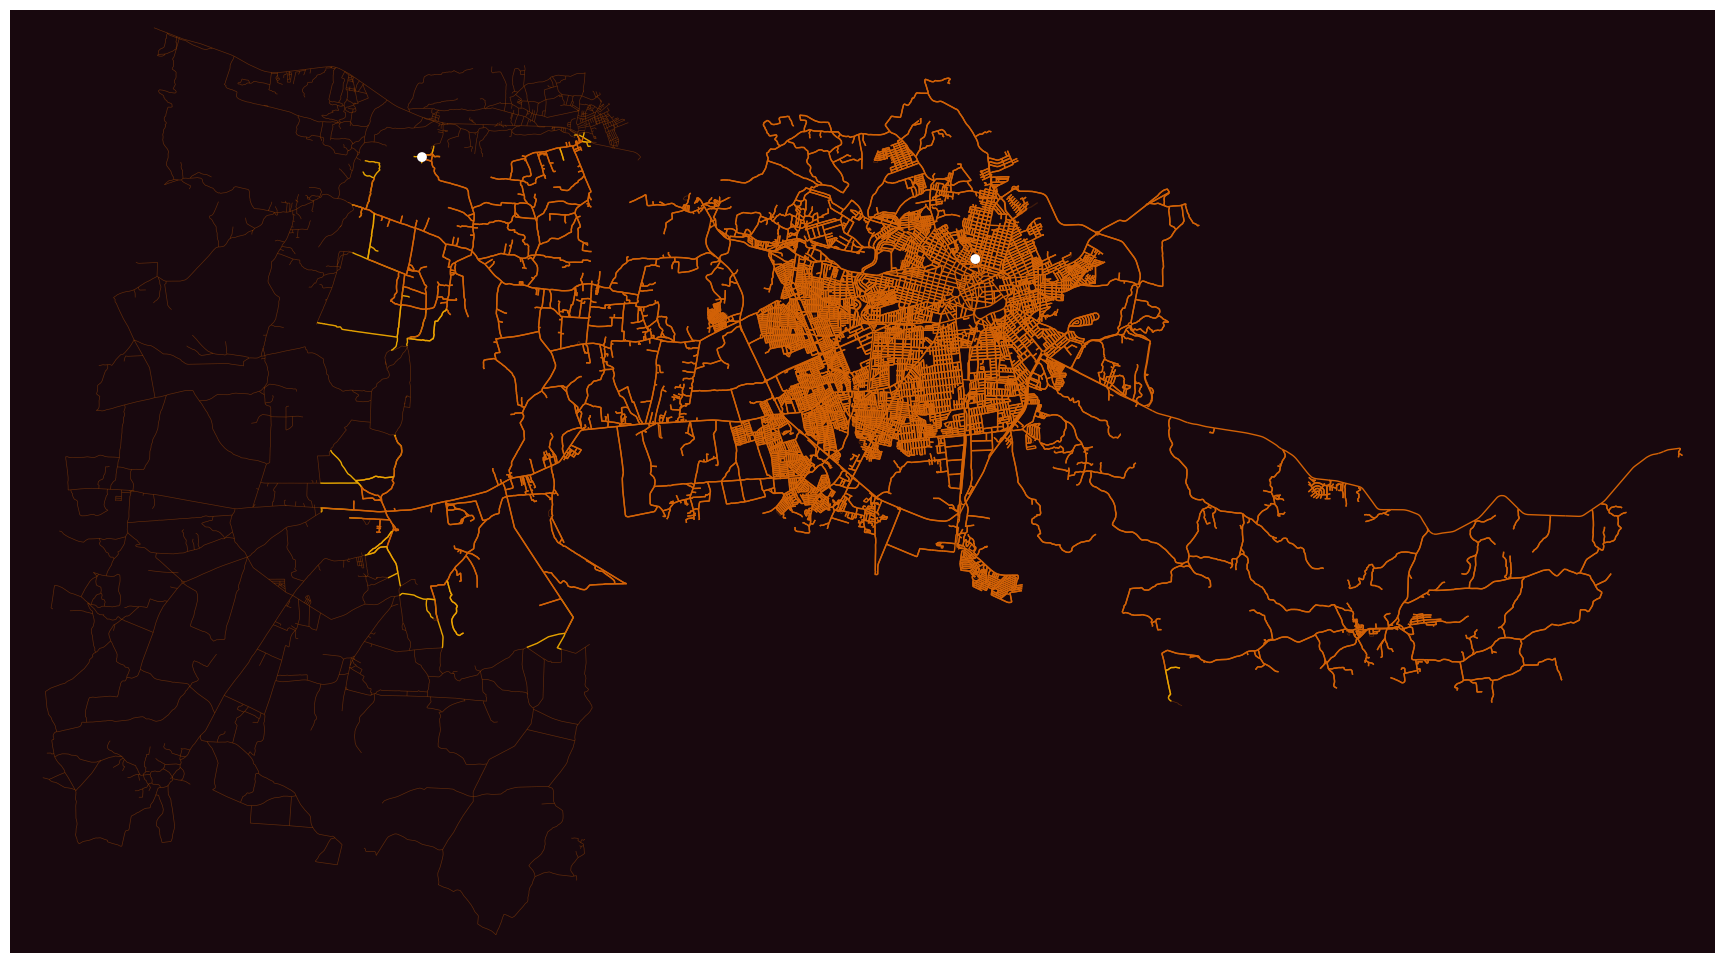

In [53]:
dijkstra(start, end, plot=False, save=True)

Distance: 19.801309999999987
Avg. speed: 41.570247933884296
Total time: 28.580021988071554


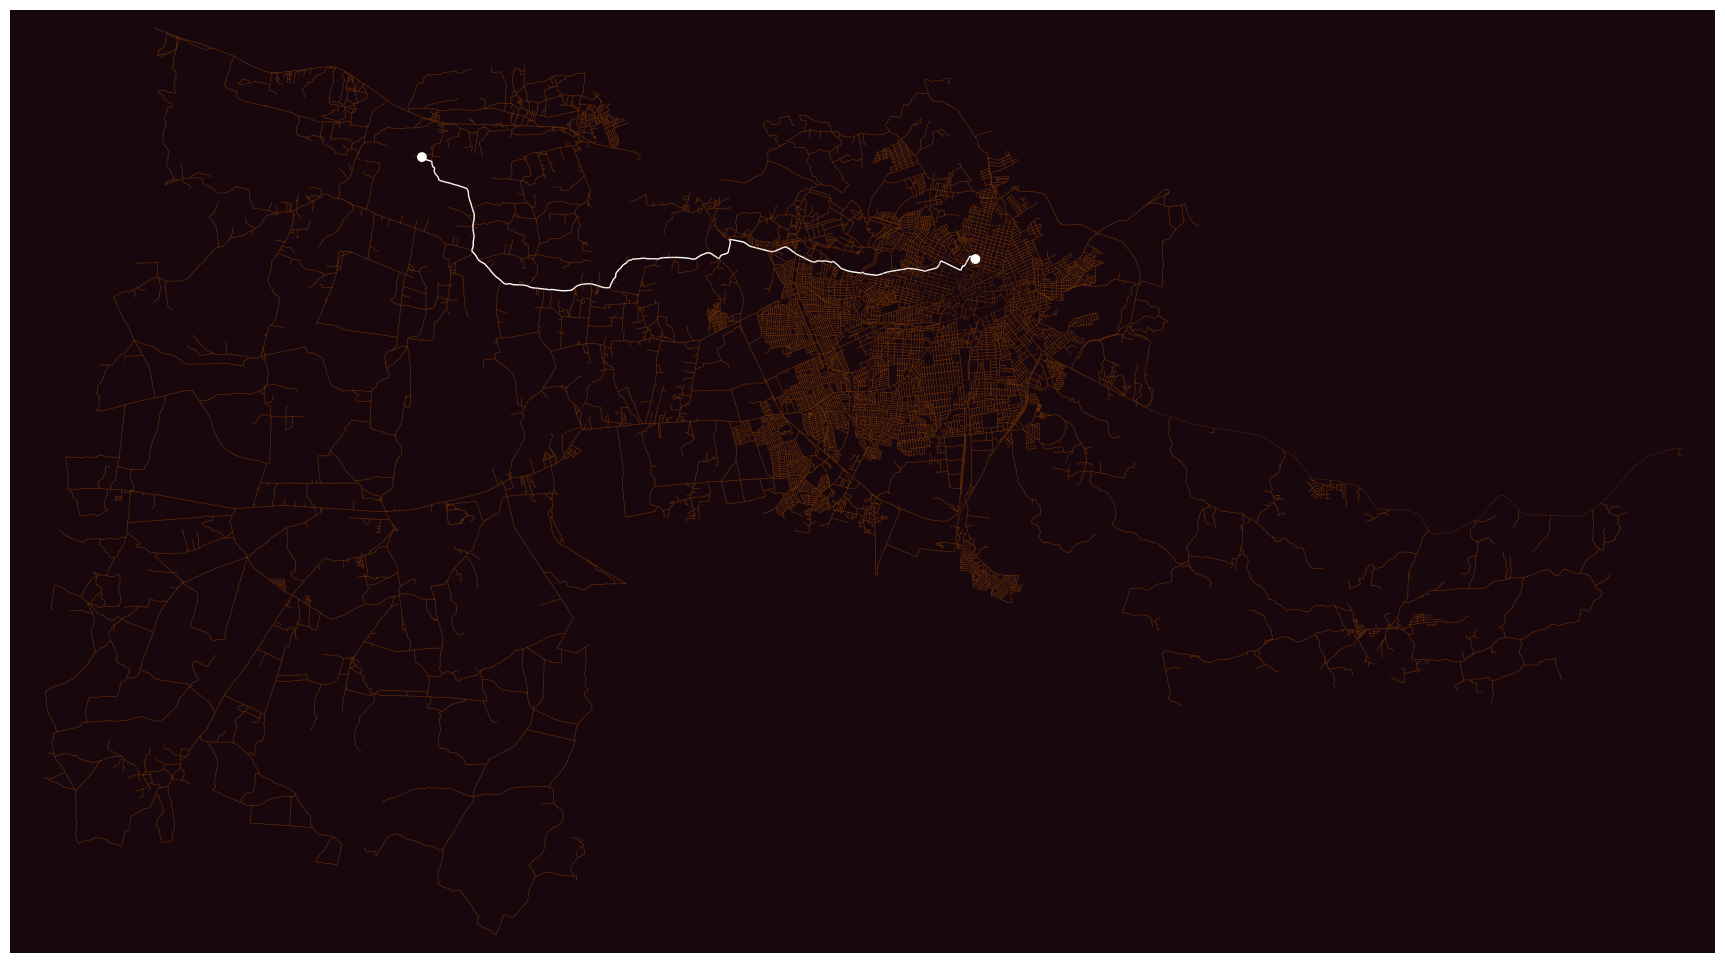

In [54]:
reconstruct_path(start, end, plot=True, algorithm_name="dijkstra")

Iterations: 6010


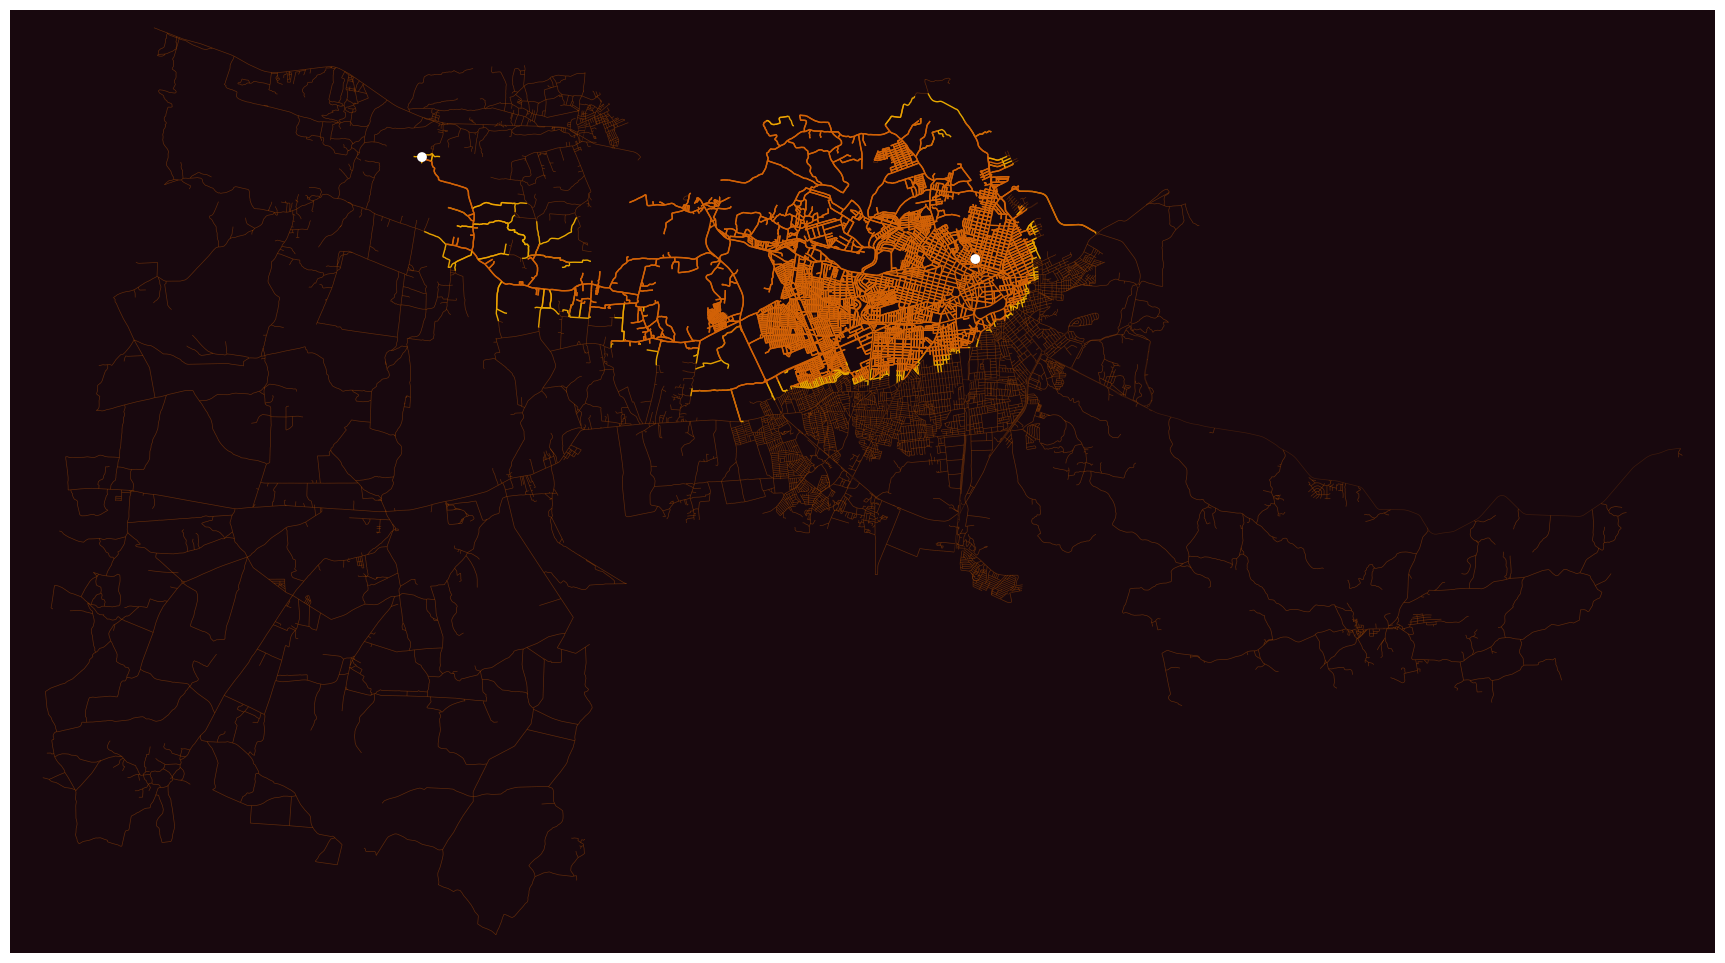

In [55]:
a_star(start, end, plot=False, save=True)

Distance: 19.801309999999987
Avg. speed: 41.570247933884296
Total time: 28.580021988071554


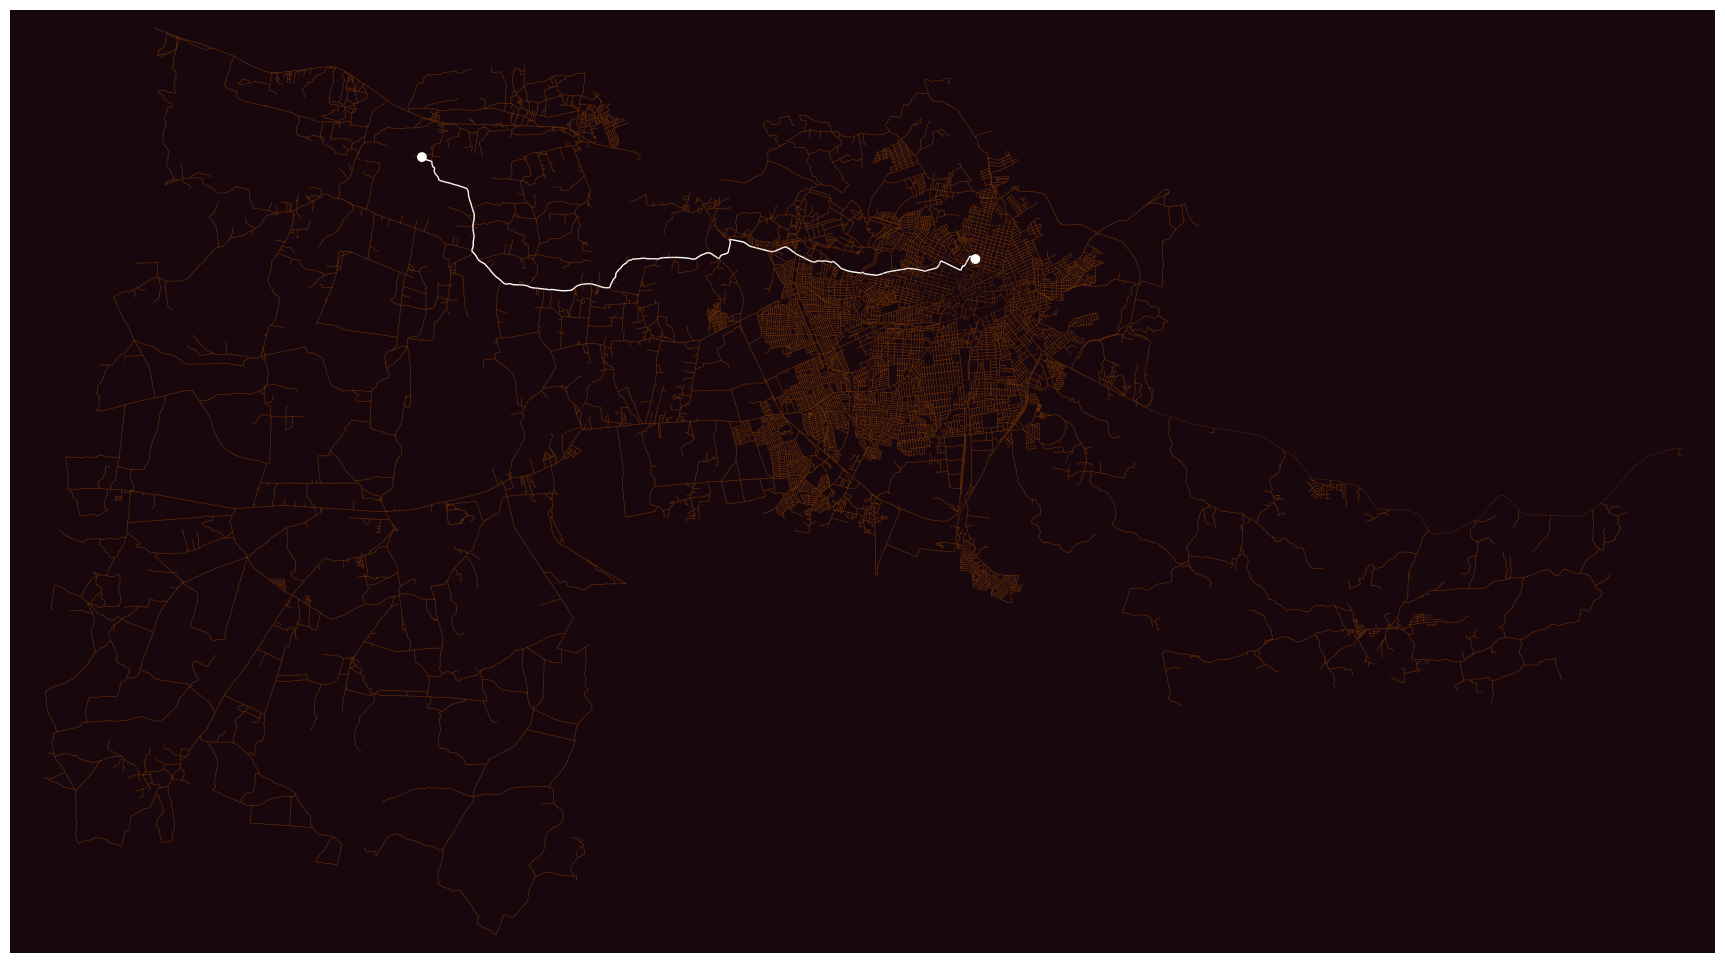

In [56]:
reconstruct_path(start, end, plot=True, algorithm_name="astar")

## Comparando os dois algoritmos em outro local de origem e destino.

In [19]:
N = 1 # Número de vezes para executar cada algortimo.
for edge in G.edges:
    G.edges[edge]["dijkstra_uses"] = 0
    G.edges[edge]["a_star_uses"] = 0

Iterations: 10010
Distance: 10.339618000000005
Avg. speed: 43.30275229357798
Total time: 14.326504601694923
Iterations: 5429
Distance: 10.46175700000001
Avg. speed: 39.83471074380165
Total time: 15.757750170124496


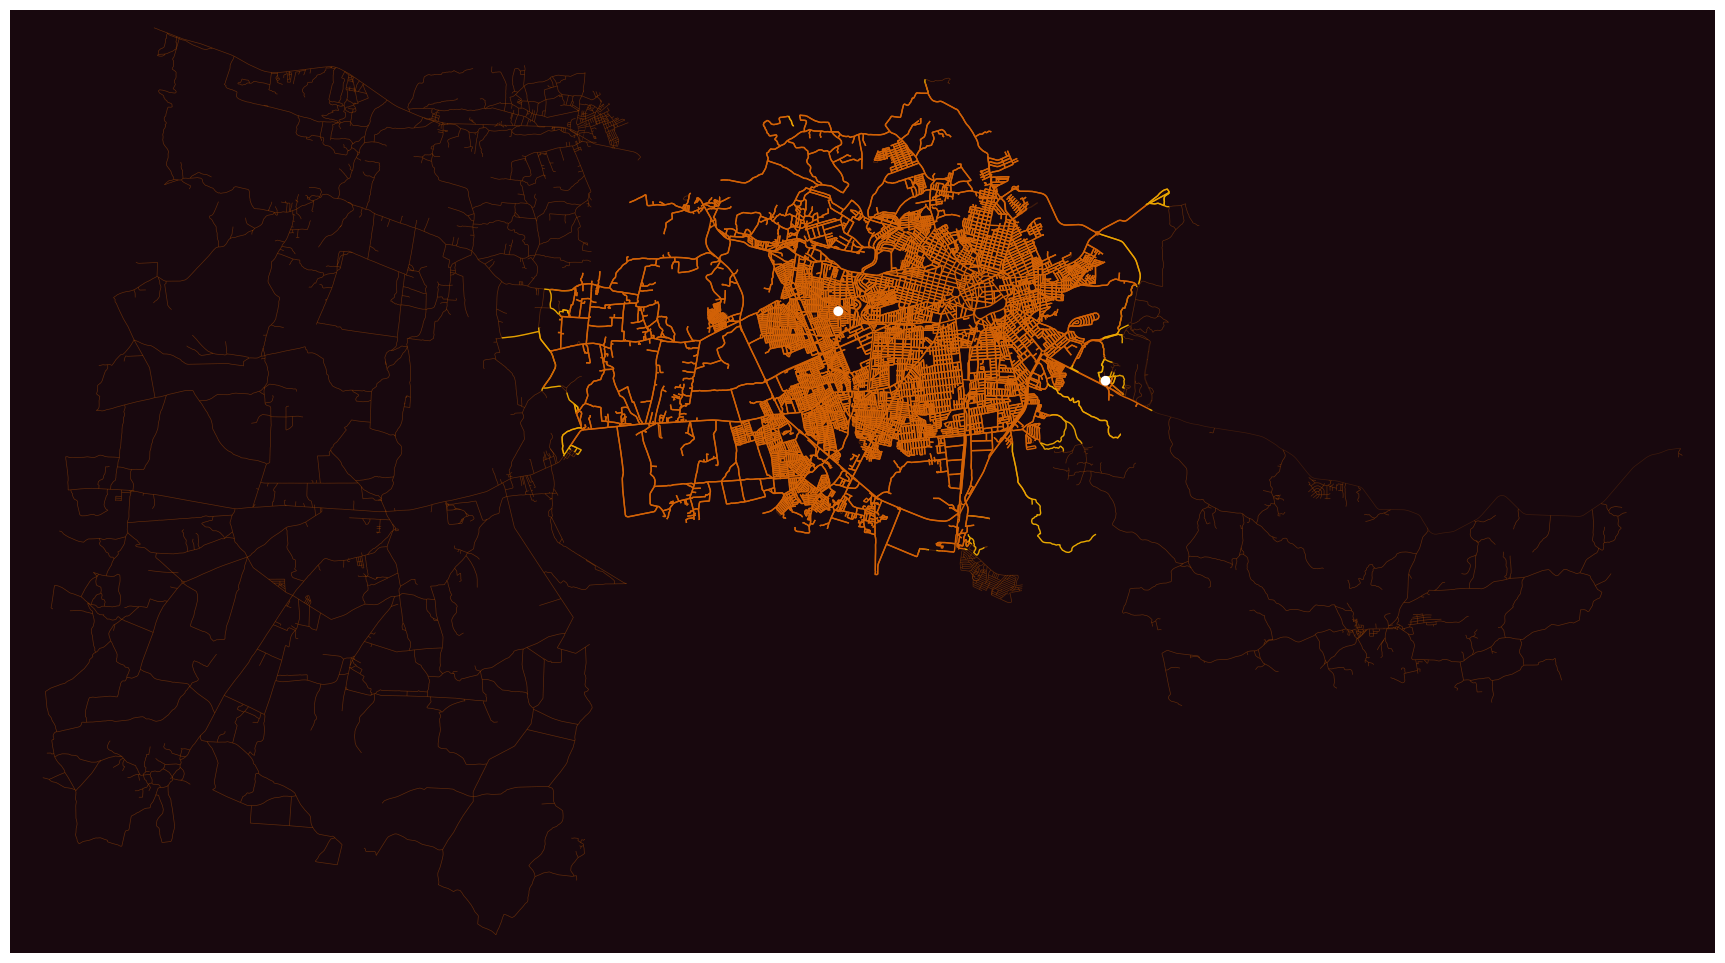

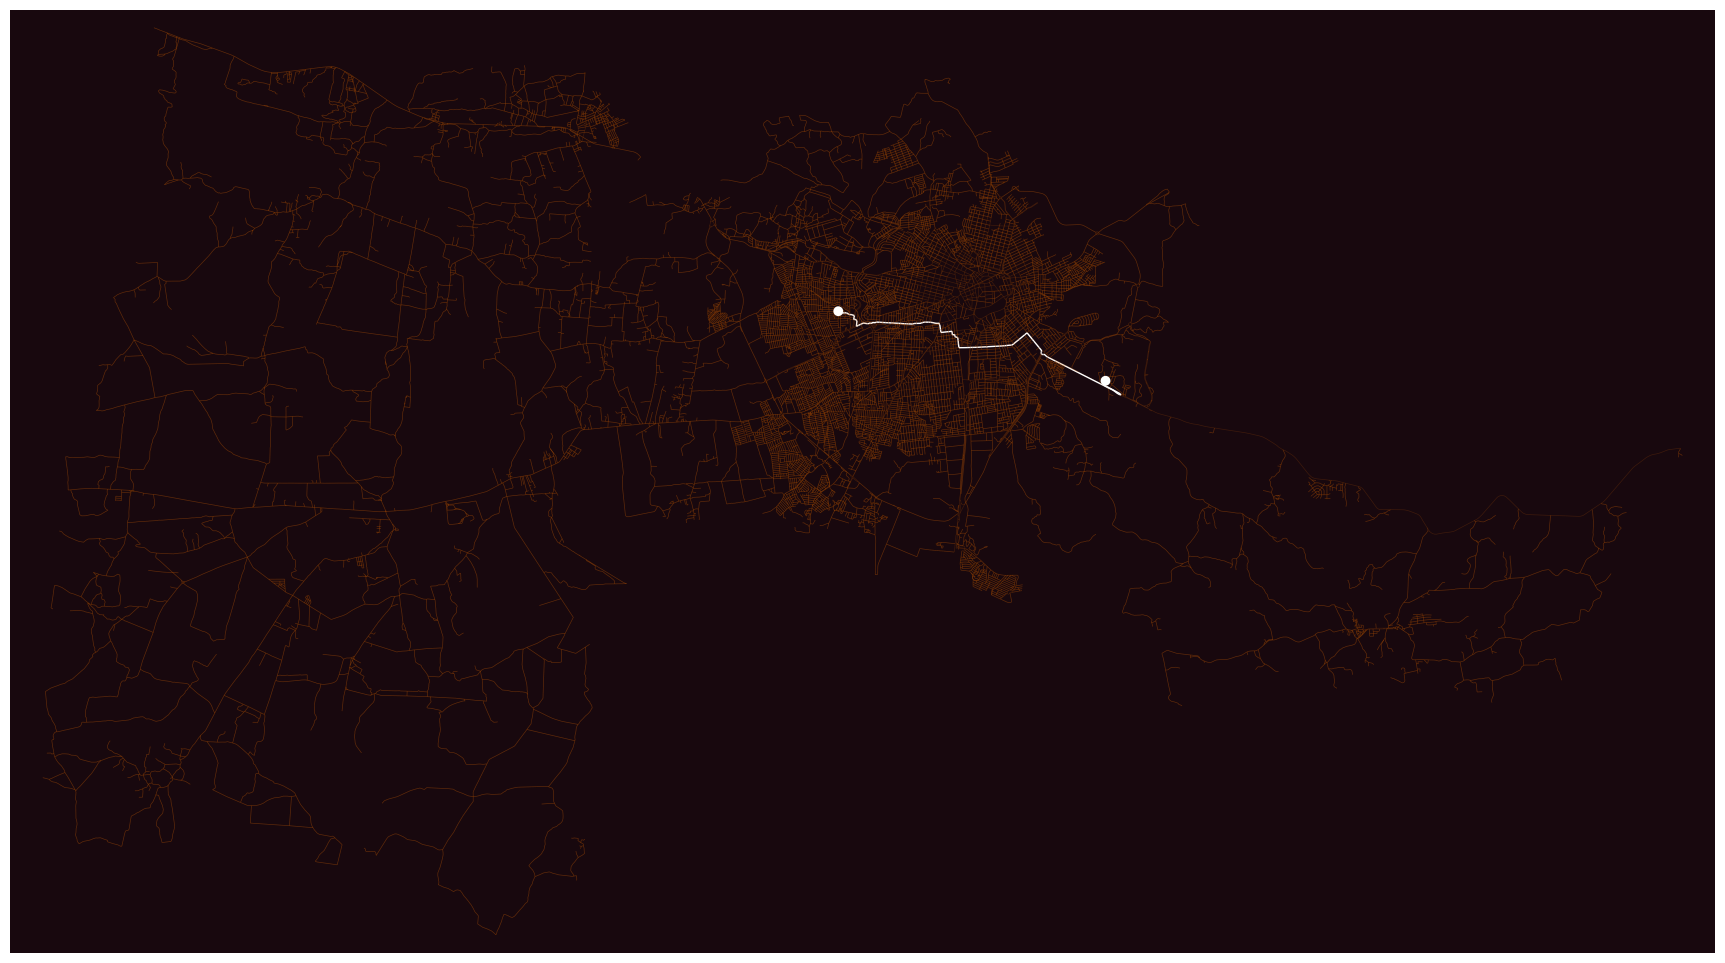

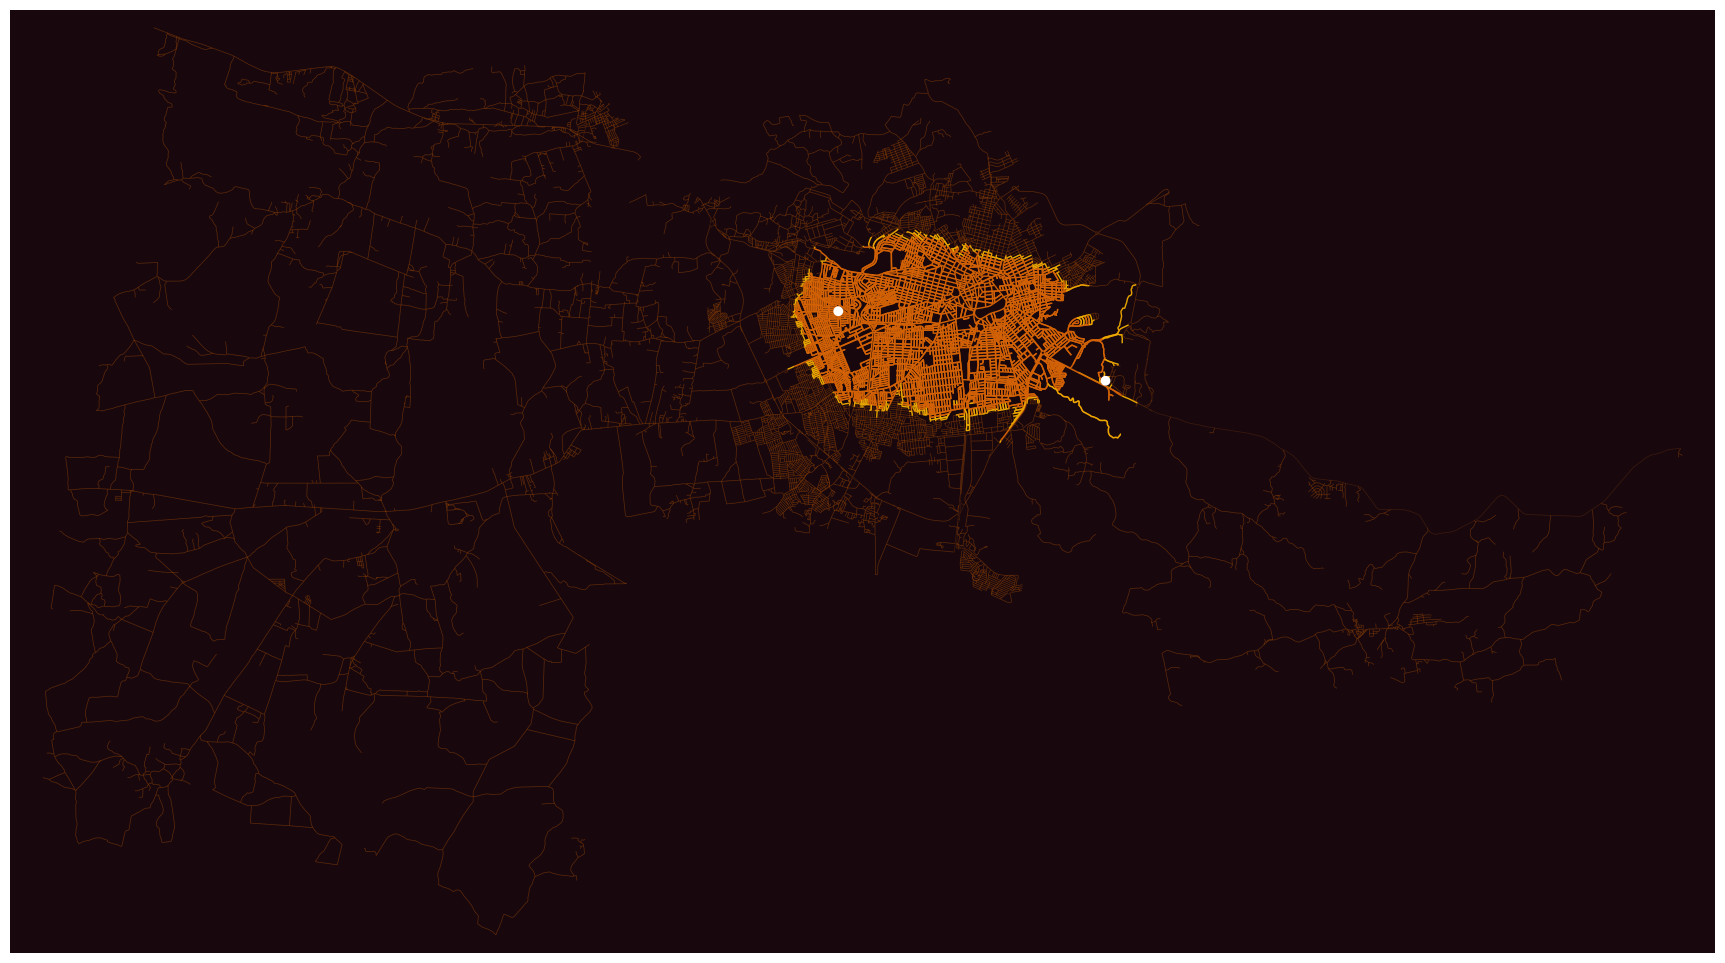

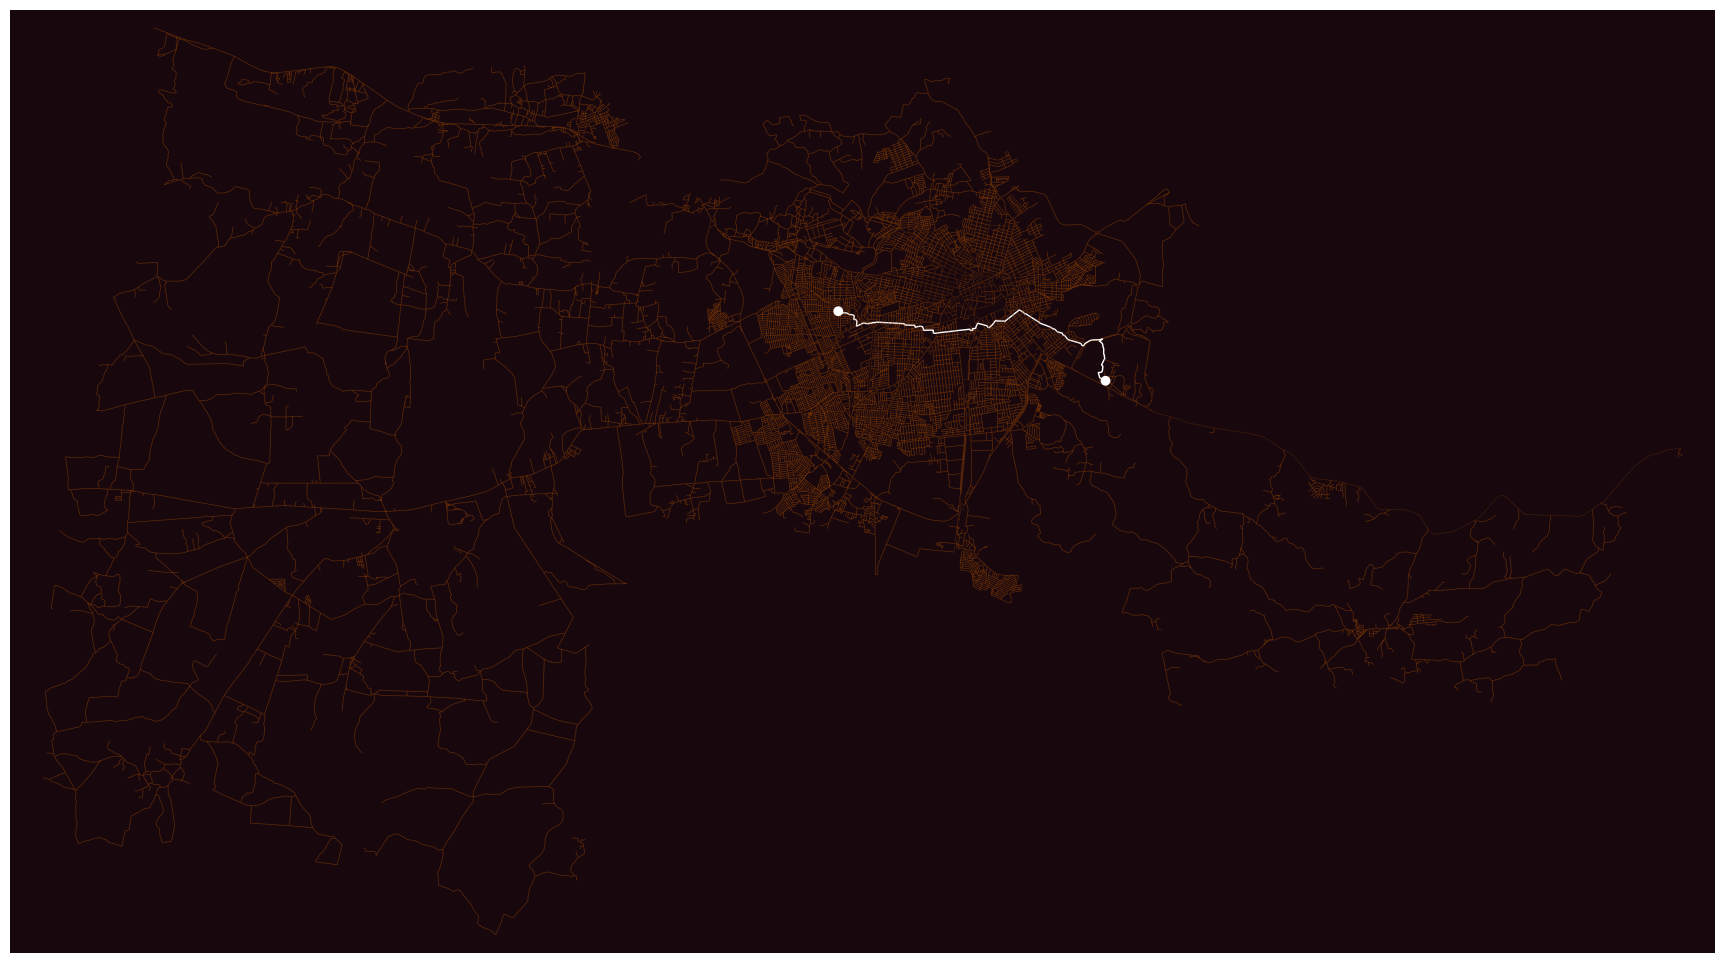

In [68]:
# Comparando o algoritmo de Disjkstra e A* para uma mesma origem e destino
# escolhido aleatóriamente.
for _ in range(N):
    start = random.choice(list(G.nodes))
    end = random.choice(list(G.nodes))
    dijkstra(start, end)
    reconstruct_path(start, end, plot=True, algorithm="dijkstra")
    a_star(start, end)
    reconstruct_path(start, end, plot=True, algorithm="a_star")

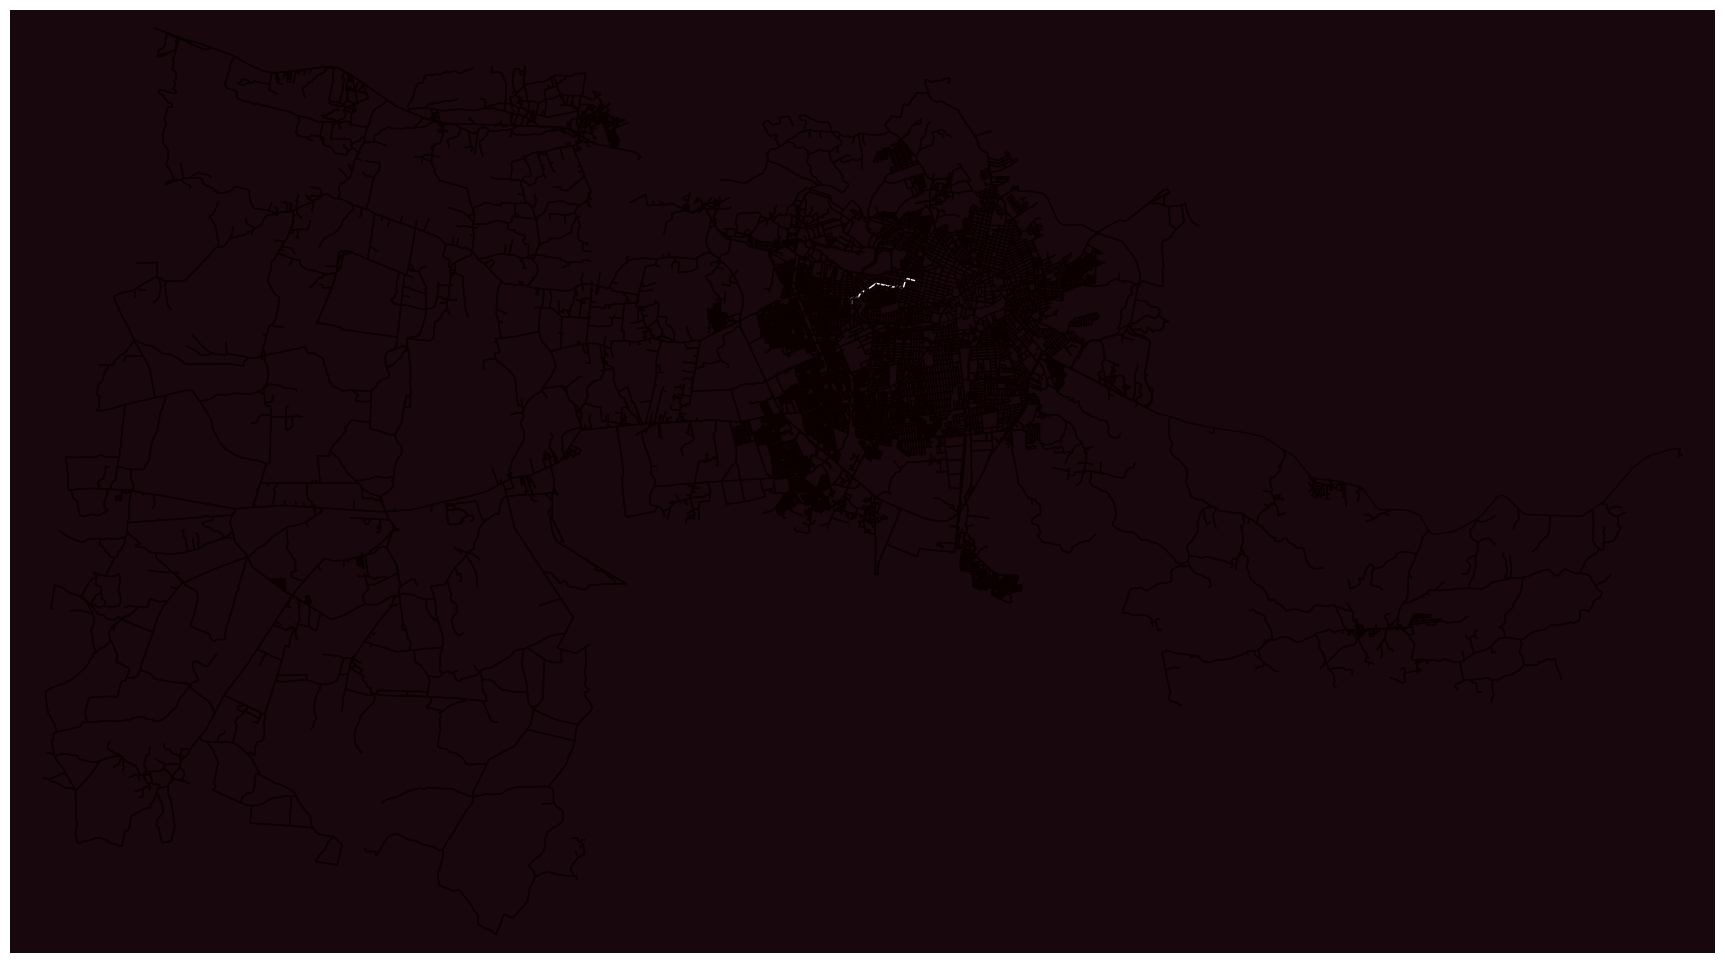

In [21]:
plot_heatmap("dijkstra")

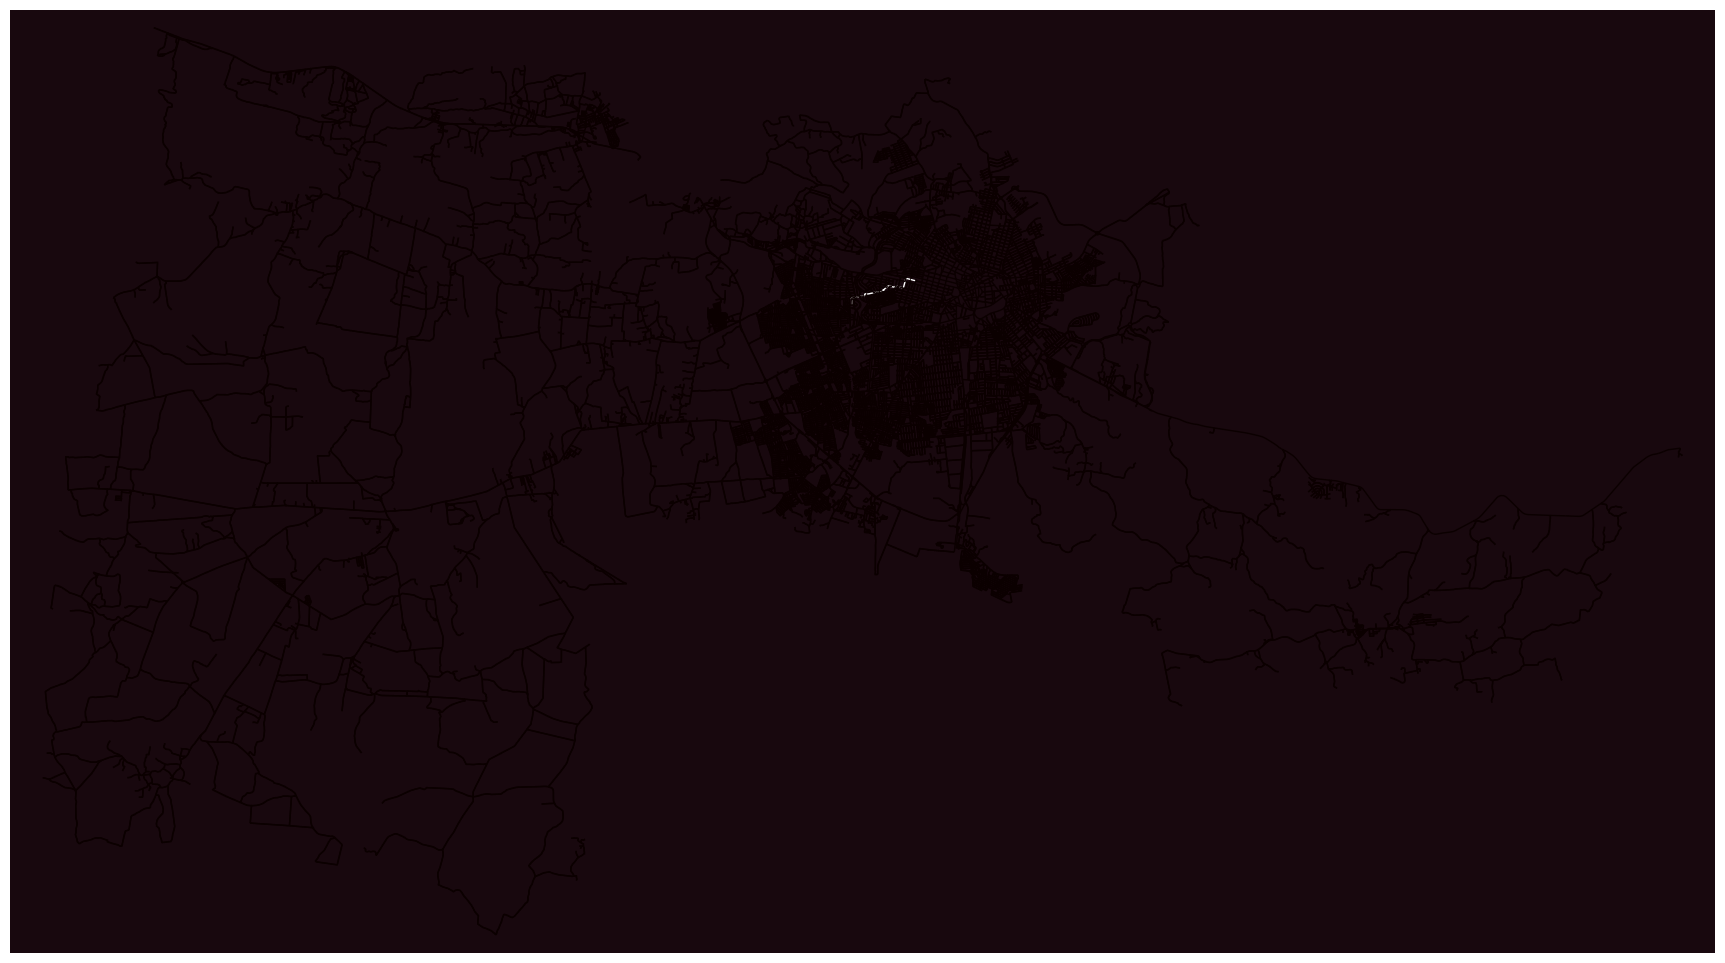

In [22]:
plot_heatmap("a_star")

# Preparando para criar o video dos Algoritmos.

In [23]:
# Função para deletar caso necessário deletar todas imagens ou vídeos de um
# diretório.
def delete_archives(path):
  dir = f'{path}'
  try:
    shutil.rmtree(dir)
  except:
    pass

In [24]:
# Criando vídeo dos algoritmos com base nas imagens geradas para cada um deles.
def create_video(algorith_name):
  step = count_archives(f"./images/{algorith_name}")
  frames = [f"./images/{algorith_name}/frame_{i}.png" for i in range(0, step)]
  clip = ImageSequenceClip(frames, fps=60)

  number_of_videos_saved = 0
  try:
    number_of_videos_saved = count_archives(f"./videos/{algorith_name}")
  except:
    create_dir(f"./videos/{algorith_name}")
    number_of_videos_saved = count_archives(f"./videos/{algorith_name}")

  video_name = f"{algorith_name}{number_of_videos_saved + 1}.mp4"
  clip.write_videofile(f"./videos/{algorith_name}/{video_name}")
  print(f"Video saved as {video_name}")

In [25]:
algorith_name = "dijkstra"
#create_video(algorith_name)

algorith_name = "astar"
#create_video(algorith_name)



In [26]:
delete_archives("./images/dijkstra")
delete_archives("./images/astar")
#delete_archives("./videos")